<a href="https://colab.research.google.com/github/KieranMalandain/heston-pinn-project/blob/main/bsm_pinn_project_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heston PINN Project Code - BSM

We aim to build fast, differentiable surrogates for European option prices under Heston stochastic- volatility models using PINNs. The goal is to train a model that is able to accurately and instantaneously price options, compute Greeks via AutoDiff, and efficiently calibrate to real time market data.

We begin by building the framework via a simpler BSM model.

## BSM Model Code

***

first we are creating the BSM model, most of the code will be reusable for heston.

***

### Building NN Architecture

now need to actually build the nn architecture

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

torch.manual_seed(14)
np.random.seed(14)

Using device: cuda


In [ ]:
class PINN(nn.Module):
  def __init__(self, num_layers=4, hidden_size=50, t_domain=(0.,1.), s_domain=(0.,200.)):
    super(PINN, self).__init__()

    self.t_min, self.t_max = t_domain
    self.s_min, self.s_max = s_domain

    self.t_range = self.t_max - self.t_min
    self.s_range = self.s_max - self.s_min

    layers = [nn.Linear(2, hidden_size), nn.Tanh()]

    for _ in range(num_layers - 1):
      layers.extend([nn.Linear(hidden_size, hidden_size), nn.Tanh()])
    layers.append(nn.Linear(hidden_size, 1))
    layers.append(nn.Softplus())

    self.net = nn.Sequential(*layers)

  def forward(self, t, s):
    t_norm = 2. * (t - self.t_min) / self.t_range - 1.
    s_norm = 2. * (s - self.s_min) / self.s_range - 1.

    x = torch.cat((t_norm, s_norm), dim=1)
    return self.net(x)

  def compute_pde_residual(self, t, s, r, sigma, q=0.):
    t_norm = 2. * (t - self.t_min) / self.t_range - 1.
    s_norm = 2. * (s - self.s_min) / self.s_range - 1.

    t_norm.requires_grad_(True)
    s_norm.requires_grad_(True)

    x = torch.cat((t_norm, s_norm), dim=1)
    u = self.net(x)

    grads = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_t_norm = grads[:, 0:1]
    u_s_norm = grads[:, 1:2]

    u_ss_norm = torch.autograd.grad(u_s_norm, x, grad_outputs=torch.ones_like(u_s_norm), create_graph=True)[0][:, 1:2]

    u_t = u_t_norm * 2. / self.t_range
    u_s = u_s_norm * 2. / self.s_range
    u_ss = u_ss_norm * (2. / self.s_range)**2

    residual = u_t + (r - q) * s * u_s + 0.5 * sigma**2 * s**2 * u_ss - r * u
    return residual

  def init_weights(self):
    def init(m):
      if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
          m.bias.data.fill_(0.01)
    self.apply(init)

### New Training Function

In [ ]:
def train_model(model, params, hyperparams):
  optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams['lr'])

  scheduler = torch.optim.lr_scheduler.StepLR(
      optimizer,
      step_size=hyperparams.get('scheduler_step_size', 1000),
      gamma=hyperparams.get('scheduler_gamma', 0.9)
  )

  loss_history = []

  print("Starting training...")
  start_time = time.time()

  for epoch in range(hyperparams['epochs']):
    optimizer.zero_grad()

    ### Calculate the loss for the boundary conditions

    s_boundary = torch.linspace(
        0,
        2*params['K'],
        hyperparams['num_boundary_points']
      ).view(-1, 1).to(device)

    t_boundary = torch.full_like(s_boundary, params['T']).to(device)

    u_boundary_pred = model(t_boundary, s_boundary)

    payoff = torch.relu(s_boundary - params['K'])

    loss_bc = nn.MSELoss()(u_boundary_pred, payoff)

    ### PDE Residual Loss

    t_collocation = torch.rand(hyperparams['num_collocation_points'], 1).to(device) * params['T']
    s_collocation = torch.rand(hyperparams['num_collocation_points'], 1).to(device) * (2 * params['K'])

    residual = model.compute_pde_residual(t_collocation, s_collocation, params['r'], params['sigma'], q=params.get('q', 0.))
    loss_pde = torch.mean(residual**2)

    lambda_pde = hyperparams.get('lambda_pde', 1.)

    total_loss = loss_bc + lambda_pde * loss_pde

    total_loss.backward()
    optimizer.step()
    scheduler.step()

    loss_history.append(total_loss.item())

    if (epoch + 1) % 600 == 0:
      current_lr = optimizer.param_groups[0]['lr']
      print(f"Epoch {epoch+1}/{hyperparams['epochs']}, Loss: {total_loss.item():.6f}, LR: {current_lr:.6f}")

  end_time = time.time()
  print(f"Training time: {end_time - start_time:.2f} seconds")

  return model, loss_history

### Evaluation Function

In [ ]:
def analytical_bsm_call(S, K, T, t, r, sigma, q=0.):
  tau = T - t

  # Handle tau close to zero element-wise
  is_tau_zero = torch.isclose(tau, torch.tensor(0.))
  # If tau is close to zero, the price is the intrinsic value max(S-K, 0)
  # Otherwise, calculate using the Black-Scholes formula

  d1 = (torch.log(S / K) + (r - q + 0.5 * sigma**2) * tau) / (sigma * torch.sqrt(tau))
  d2 = d1 - sigma * torch.sqrt(tau)

  N_d1 = .5 * (1 + torch.erf(d1 / torch.sqrt(torch.tensor(2.))))
  N_d2 = .5 * (1 + torch.erf(d2 / torch.sqrt(torch.tensor(2.))))

  bsm_price = S * torch.exp(-q * tau) * N_d1 - K * torch.exp(-r * tau) * N_d2

  price = torch.where(is_tau_zero, torch.relu(S - K), bsm_price)

  return price

### Run script

Starting training...
Epoch 600/20000, Loss: 0.954710, LR: 0.010000
Epoch 1200/20000, Loss: 0.439667, LR: 0.010000
Epoch 1800/20000, Loss: 0.237430, LR: 0.010000
Epoch 2400/20000, Loss: 0.025662, LR: 0.006800
Epoch 3000/20000, Loss: 0.037896, LR: 0.006800
Epoch 3600/20000, Loss: 0.027142, LR: 0.006800
Epoch 4200/20000, Loss: 0.011346, LR: 0.004624
Epoch 4800/20000, Loss: 0.023577, LR: 0.004624
Epoch 5400/20000, Loss: 0.073853, LR: 0.004624
Epoch 6000/20000, Loss: 0.021371, LR: 0.003144
Epoch 6600/20000, Loss: 0.008552, LR: 0.003144
Epoch 7200/20000, Loss: 0.009254, LR: 0.003144
Epoch 7800/20000, Loss: 0.008536, LR: 0.003144
Epoch 8400/20000, Loss: 0.005704, LR: 0.002138
Epoch 9000/20000, Loss: 0.009578, LR: 0.002138
Epoch 9600/20000, Loss: 0.007041, LR: 0.002138
Epoch 10200/20000, Loss: 0.004600, LR: 0.001454
Epoch 10800/20000, Loss: 0.006418, LR: 0.001454
Epoch 11400/20000, Loss: 0.007311, LR: 0.001454
Epoch 12000/20000, Loss: 0.005495, LR: 0.000989
Epoch 12600/20000, Loss: 0.003965, L

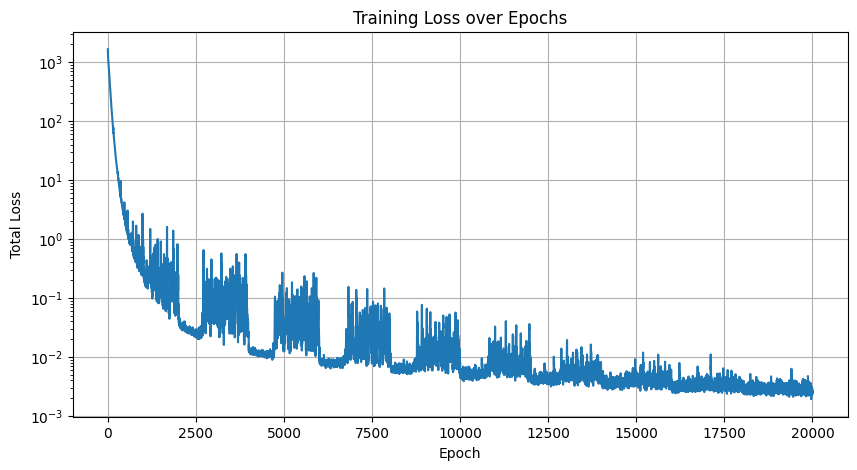

In [ ]:
if __name__ == '__main__':
  physical_params = {
      'K': 100.0,
      'r': 0.05,
      'sigma': 0.2,
      'T': 1.0,
      'q': 0.0
  }

  training_hyperparams = {
      'epochs': 20000,
      'lr': 1e-2,
      'num_boundary_points': 200,
      'num_collocation_points': 20000,
      'scheduler_step_size': 2000,
      'scheduler_gamma': 0.68,
      'lambda_pde': 0.8
  }

  s_min, s_max = 0., 2 * physical_params['K']
  t_min, t_max = 0., physical_params['T']

  pinn_bsm = PINN(t_domain=(t_min, t_max), s_domain=(s_min, s_max)).to(device)

  pinn_bsm.init_weights()
  pinn_bsm.train()

  trained_pinn, history = train_model(
      model=pinn_bsm,
      params=physical_params,
      hyperparams=training_hyperparams
  )

  plt.figure(figsize=(10, 5))
  plt.plot(history)
  plt.title('Training Loss over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Total Loss')
  plt.yscale('log')
  plt.grid(True)
  plt.show()

### Evaluation

In [ ]:
print("Evaluating model...")

trained_pinn.eval()

S_vals = torch.linspace(s_min, s_max, 100).to(device)
t_vals = torch.linspace(t_min, t_max, 100).to(device)

S_grid, t_grid = torch.meshgrid(S_vals, t_vals, indexing='xy')

S_flat = S_grid.flatten().view(-1,1)
t_flat = t_grid.flatten().view(-1,1)


with torch.no_grad():
  u_pinn = trained_pinn(t_flat, S_flat).reshape(S_grid.shape)

u_true = analytical_bsm_call(
    S_grid,
    physical_params['K'],
    physical_params['T'],
    t_grid,
    physical_params['r'],
    physical_params['sigma'],
    q=physical_params.get('q', 0.)
  ).reshape(S_grid.shape)

S_grid_cpu = S_grid.cpu().numpy()
t_grid_cpu = t_grid.cpu().numpy()
u_pinn_cpu = u_pinn.cpu().numpy()
u_true_cpu = u_true.cpu().numpy()

error = np.linalg.norm(u_pinn_cpu - u_true_cpu, ord=np.inf) / np.linalg.norm(u_true_cpu, ord=np.inf)
print(f"Relative L2 Error: {error:.4e}")

Evaluating model...
Relative L2 Error: 6.5020e-02


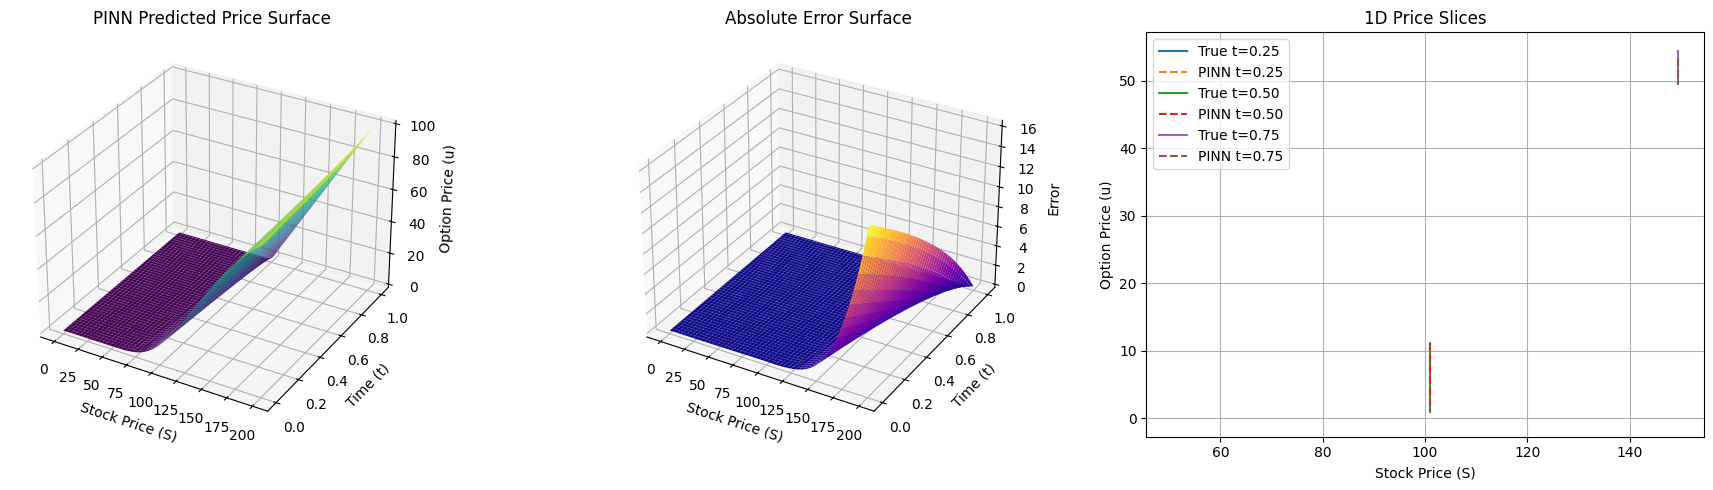

In [ ]:
# --- Plotting ---

# Plot 1: 3D Surface of PINN Prediction
fig = plt.figure(figsize=(18, 5))
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(S_grid_cpu, t_grid_cpu, u_pinn_cpu, cmap='viridis')
ax1.set_title('PINN Predicted Price Surface')
ax1.set_xlabel('Stock Price (S)')
ax1.set_ylabel('Time (t)')
ax1.set_zlabel('Option Price (u)')

# Plot 2: 3D Surface of Absolute Error
ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(S_grid_cpu, t_grid_cpu, np.abs(u_pinn_cpu - u_true_cpu), cmap='plasma')
ax2.set_title('Absolute Error Surface')
ax2.set_xlabel('Stock Price (S)')
ax2.set_ylabel('Time (t)')
ax2.set_zlabel('Error')

# Plot 3: 1D Slices at different times
ax3 = fig.add_subplot(133)
times_to_plot = [0.25, 0.5, 0.75]
for t_slice in times_to_plot:
    idx = np.abs(t_vals.cpu().numpy() - t_slice).argmin()
    ax3.plot(S_grid_cpu[:, idx], u_true_cpu[:, idx], label=f'True t={t_slice:.2f}')
    ax3.plot(S_grid_cpu[:, idx], u_pinn_cpu[:, idx], '--', label=f'PINN t={t_slice:.2f}')
ax3.set_title('1D Price Slices')
ax3.set_xlabel('Stock Price (S)')
ax3.set_ylabel('Option Price (u)')
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()

### Results:

Here, I'll add in the results that we get. After the edits, the vanilla model (without any scheduling, etc.) and an Adam optimizer, returns an L2 relative error (after evaluating) of 7.1513e-02. Our training loss is:

```
Starting training...
Epoch 1000/20000, Loss: 204.106689
Epoch 2000/20000, Loss: 36.538734
Epoch 3000/20000, Loss: 7.078441
Epoch 4000/20000, Loss: 1.501305
Epoch 5000/20000, Loss: 0.368640
Epoch 6000/20000, Loss: 0.106739
Epoch 7000/20000, Loss: 0.048877
Epoch 8000/20000, Loss: 0.024940
Epoch 9000/20000, Loss: 0.015474
Epoch 10000/20000, Loss: 0.010408
Epoch 11000/20000, Loss: 0.013228
Epoch 12000/20000, Loss: 0.012120
Epoch 13000/20000, Loss: 0.007822
Epoch 14000/20000, Loss: 0.008392
Epoch 15000/20000, Loss: 0.005449
Epoch 16000/20000, Loss: 0.005057
Epoch 17000/20000, Loss: 0.009727
Epoch 18000/20000, Loss: 0.004194
Epoch 19000/20000, Loss: 0.003224
Epoch 20000/20000, Loss: 0.005654
Training time: 231.92 seconds
```

Adding in the `lr` scheduler, with `gamma=0.68` decreasing every 2000 `epoch`s, gives us a final L2 error of 6.4888e-02, which is slightly lower than before.

***

***

***

***

### Edit Notes from things going wrong

Running with the original code, we get the following:

```
Starting training...
Epoch 1000/20000, Loss: 264.118988
Epoch 2000/20000, Loss: 51.196018
Epoch 3000/20000, Loss: 10.825339
Epoch 4000/20000, Loss: 2.842824
Epoch 5000/20000, Loss: 0.898554
Epoch 6000/20000, Loss: 0.623476
Epoch 7000/20000, Loss: 0.263038
Epoch 8000/20000, Loss: 0.113006
Epoch 9000/20000, Loss: 0.053258
Epoch 10000/20000, Loss: 0.042842
Epoch 11000/20000, Loss: 0.035708
Epoch 12000/20000, Loss: 0.031909
Epoch 13000/20000, Loss: 0.029446
Epoch 14000/20000, Loss: 0.024515
Epoch 15000/20000, Loss: 0.022751
Epoch 16000/20000, Loss: 0.020704
Epoch 17000/20000, Loss: 0.018492
Epoch 18000/20000, Loss: 0.021734
Epoch 19000/20000, Loss: 0.016962
Epoch 20000/20000, Loss: 0.022009
Training time: 244.51 seconds
```
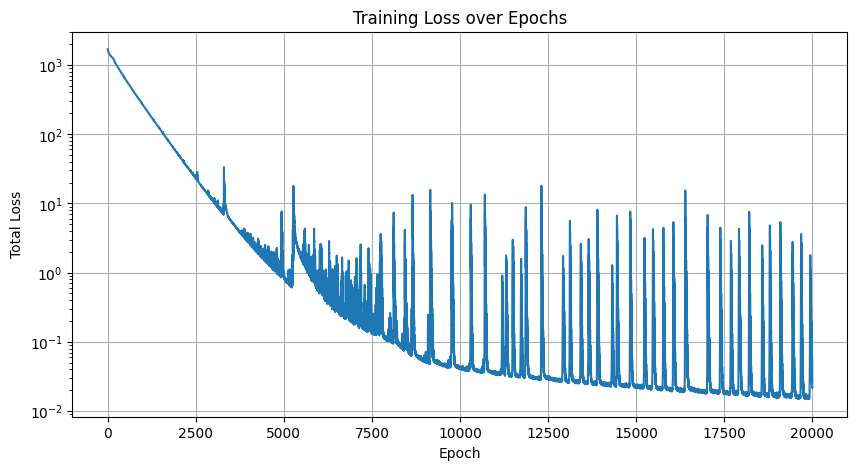

We need to do something to edit this since something is going on with our loss function. My guess is because the losses are of different scales, so let's try and 'normalise' these so to speak.

We did this by running the following code:

```
pinn_bsm.eval()


with torch.no_grad():
  # Use a different set of points for each check to be rigorous
  s_boundary_check = torch.linspace(0, 2*physical_params['K'], 1000).view(-1, 1).to(device)
  t_boundary_check = torch.full_like(s_boundary_check, physical_params['T']).to(device)

  u_boundary_check = pinn_bsm(t_boundary_check, s_boundary_check)
  payoff = torch.relu(s_boundary_check - physical_params['K'])
  initial_loss_bc = nn.MSELoss()(u_boundary_check, payoff)

t_collocation_check = torch.rand(1000, 1).to(device) * physical_params['T']
s_collocation_check = torch.rand(1000, 1).to(device) * (2 * physical_params['K'])

residual = pde_residual(
    pinn_bsm,
    t_collocation_check,
    s_collocation_check,
    physical_params['r'],
    physical_params['sigma'],
    q=physical_params.get('q', 0.0)
)

initial_loss_pde = torch.mean(residual**2)

suggested_lambda = initial_loss_bc.item() / initial_loss_pde.item()
print(f"Initial BC Loss: {initial_loss_bc.item():.6f}")
print(f"Initial PDE Loss: {initial_loss_pde.item():.6f}")
print(f"Suggested lambda_pde: {suggested_lambda:.2f}")

```

which returned:

```
--- Calculating Initial Loss Magnitudes for Lambda Heuristic ---
Initial BC Loss: 1665.330322
Initial PDE Loss: 0.000173
Suggested lambda_pde: 9604463.31
```

We see that this is a ridiculous suggestion, but not quite sure why the pde loss is so small in the first place. it seems unlikely that this would happen by chance. To try and find a solution, we coded a diagnostic run to see what the gradients were. Here are the results:

```
--- Running a single diagnostic test for pde_residual ---
--- Derivative Sanity Check ---
Mean of u:    0.268603
Mean of u_t:  0.000832
Mean of u_s:  0.000121
Mean of u_ss: -0.000418
-----------------------------
Mean of squared residual: 0.000173
--- Diagnostic test complete ---
```

It looks as though we are facing the problem of vanishing gradients. We can counteract this by using Glorot initialisation for `tanh`, which should help us. To do so, we'll code in a new initialisation function, and modify the main starting code. After doing this, here's what we get:

```
--- Running diagnostic test with Xavier Initialization ---
--- Derivative Sanity Check ---
Mean of u:    -0.808496
Mean of u_t:  -0.011880
Mean of u_s:  -0.004562
Mean of u_ss: 0.000680
-----------------------------
Mean of squared residual: 0.002522
--- Diagnostic test complete ---

--- Recalculating Lambda Heuristic with New Initialization ---
Initial BC Loss: 1713.271240
Initial PDE Loss: 0.002522
Suggested lambda_pde: 679218.55
```

Our derivatives, mostly, are at least an order of magnitude larger, which is great and means Glorot has done its job. However, there's a key issue; we're seeing negative values for `u`. This is not physical and so we should edit our code to enforce the constraint that `u` must be strictly positive in an effort to help. To do so, let's place a `softplus` at the end of the network. After having done this, we get the following:

```
--- Running diagnostic test with Xavier Initialization ---
--- Derivative Sanity Check ---
Mean of u:    0.878944
Mean of u_t:  -0.015500
Mean of u_s:  0.000941
Mean of u_ss: -0.000539
-----------------------------
Mean of squared residual: 0.003523
--- Diagnostic test complete ---

--- Recalculating Lambda Heuristic with New Initialization ---
Initial BC Loss: 1625.759033
Initial PDE Loss: 0.003523
Suggested lambda_pde: 461457.61
```

Clearly this is still not satisfactory! We now look at whether normalisation is a problem.

---

Upon normalising, and cleaning up the code, and deciding that what's going on here is, to be honest, something that really is more of a learning rate/optimizer issue, we (with the following code) get some nice results:

```
import torch
import torch.nn as nn
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

torch.manual_seed(14)
np.random.seed(14)

class PINN(nn.Module):
  def __init__(self, num_layers=4, hidden_size=50, t_domain=(0.,1.), s_domain=(0.,200.)):
    super(PINN, self).__init__()

    self.t_min, self.t_max = t_domain
    self.s_min, self.s_max = s_domain

    self.t_range = self.t_max - self.t_min
    self.s_range = self.s_max - self.s_min

    layers = [nn.Linear(2, hidden_size), nn.Tanh()]

    for _ in range(num_layers - 1):
      layers.extend([nn.Linear(hidden_size, hidden_size), nn.Tanh()])
    layers.append(nn.Linear(hidden_size, 1))
    layers.append(nn.Softplus())

    self.net = nn.Sequential(*layers)
  
  def forward(self, t, s):
    t_norm = 2. * (t - self.t_min) / self.t_range - 1.
    s_norm = 2. * (s - self.s_min) / self.s_range - 1.

    x = torch.cat((t_norm, s_norm), dim=1)
    return self.net(x)
  
  def compute_pde_residual(self, t, s, r, sigma, q=0.):
    t_norm = 2. * (t - self.t_min) / self.t_range - 1.
    s_norm = 2. * (s - self.s_min) / self.s_range - 1.

    t_norm.requires_grad_(True)
    s_norm.requires_grad_(True)

    x = torch.cat((t_norm, s_norm), dim=1)
    u = self.net(x)

    grads = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_t_norm = grads[:, 0:1]
    u_s_norm = grads[:, 1:2]

    u_ss_norm = torch.autograd.grad(u_s_norm, x, grad_outputs=torch.ones_like(u_s_norm), create_graph=True)[0][:, 1:2]

    u_t = u_t_norm * 2. / self.t_range
    u_s = u_s_norm * 2. / self.s_range
    u_ss = u_ss_norm * (2. / self.s_range)**2

    residual = u_t + (r - q) * s * u_s + 0.5 * sigma**2 * s**2 * u_ss - r * u
    return residual
  
  def init_weights(self):
    def init(m):
      if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
          m.bias.data.fill_(0.01)
    self.apply(init)

def train_model(model, params, hyperparams):
  optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams['lr'])

  loss_history = []

  print("Starting training...")
  start_time = time.time()

  for epoch in range(hyperparams['epochs']):
    optimizer.zero_grad()

    ### Calculate the loss for the boundary conditions

    s_boundary = torch.linspace(
        0,
        2*params['K'],
        hyperparams['num_boundary_points']
      ).view(-1, 1).to(device)

    t_boundary = torch.full_like(s_boundary, params['T']).to(device)

    u_boundary_pred = model(t_boundary, s_boundary)

    payoff = torch.relu(s_boundary - params['K'])

    loss_bc = nn.MSELoss()(u_boundary_pred, payoff)

    ### PDE Residual Loss

    t_collocation = torch.rand(hyperparams['num_collocation_points'], 1).to(device) * params['T']
    s_collocation = torch.rand(hyperparams['num_collocation_points'], 1).to(device) * (2 * params['K'])

    residual = model.compute_pde_residual(t_collocation, s_collocation, params['r'], params['sigma'], q=params.get('q', 0.))
    loss_pde = torch.mean(residual**2)

    total_loss = loss_bc + loss_pde

    total_loss.backward()
    optimizer.step()

    loss_history.append(total_loss.item())

    if (epoch + 1) % 1000 == 0:
      print(f"Epoch {epoch+1}/{hyperparams['epochs']}, Loss: {total_loss.item():.6f}")

  end_time = time.time()
  print(f"Training time: {end_time - start_time:.2f} seconds")

  return model, loss_history

if __name__ == '__main__':
  physical_params = {
      'K': 100.0,
      'r': 0.05,
      'sigma': 0.2,
      'T': 1.0,
      'q': 0.0
  }

  training_hyperparams = {
      'epochs': 20000,
      'lr': 1e-3,
      'num_boundary_points': 200,
      'num_collocation_points': 20000
  }

  s_min, s_max = 0., 2 * physical_params['K']
  t_min, t_max = 0., physical_params['T']

  pinn_bsm = PINN(t_domain=(t_min, t_max), s_domain=(s_min, s_max)).to(device)

  pinn_bsm.init_weights()
  pinn_bsm.train()

  trained_pinn, history = train_model(
      model=pinn_bsm,
      params=physical_params,
      hyperparams=training_hyperparams
  )

  plt.figure(figsize=(10, 5))
  plt.plot(history)
  plt.title('Training Loss over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Total Loss')
  plt.yscale('log')
  plt.grid(True)
  plt.show()
```

**Results**:

```
Starting training...
Epoch 1000/20000, Loss: 204.106689
Epoch 2000/20000, Loss: 36.538734
Epoch 3000/20000, Loss: 7.078441
Epoch 4000/20000, Loss: 1.501305
Epoch 5000/20000, Loss: 0.368640
Epoch 6000/20000, Loss: 0.106739
Epoch 7000/20000, Loss: 0.048877
Epoch 8000/20000, Loss: 0.024940
Epoch 9000/20000, Loss: 0.015474
Epoch 10000/20000, Loss: 0.010408
Epoch 11000/20000, Loss: 0.013228
Epoch 12000/20000, Loss: 0.012120
Epoch 13000/20000, Loss: 0.007822
Epoch 14000/20000, Loss: 0.008392
Epoch 15000/20000, Loss: 0.005449
Epoch 16000/20000, Loss: 0.005057
Epoch 17000/20000, Loss: 0.009727
Epoch 18000/20000, Loss: 0.004194
Epoch 19000/20000, Loss: 0.003224
Epoch 20000/20000, Loss: 0.005654
Training time: 231.92 seconds
```


Image:

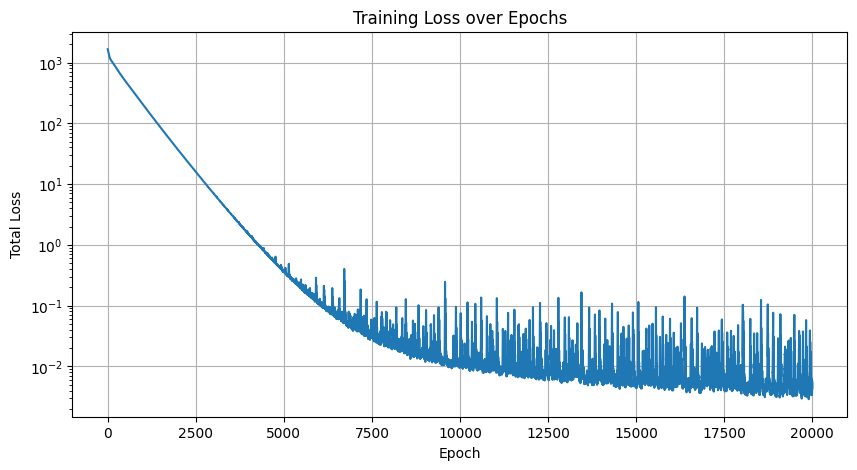